# Prophet Model for Demand Forecasting

## Assessment Task: Part 1 - Multi-Step Ahead Load Forecasting

**Objective**: Build a Prophet model to predict power demand (demand_kw) for the next 24 hours

**Requirements**:
- Use Prophet model (statistical model)
- Address data quality issues
- Predict next 24 hours
- Include visualizations and analysis

## 1. Import Libraries

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

print("Libraries imported successfully")

Libraries imported successfully


## 2. Load and Explore Data

In [79]:
df = pd.read_csv('substation_data_Ch.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"\nTime range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"\nDemand statistics:")
print(df['demand_kw'].describe())

Dataset shape: (35136, 7)
Columns: ['timestamp', 'demand_kw', 'voltage_a', 'voltage_b', 'voltage_c', 'temperature_celsius', 'humidity_percent']

Time range: 2008-01-01 00:00:00 to 2008-12-31 23:45:00
Missing values: 91

Demand statistics:
count    35126.000000
mean         1.072068
std          1.001132
min          0.000000
25%          0.314567
50%          0.605133
75%          1.549600
max         13.450400
Name: demand_kw, dtype: float64

Time range: 2008-01-01 00:00:00 to 2008-12-31 23:45:00
Missing values: 91

Demand statistics:
count    35126.000000
mean         1.072068
std          1.001132
min          0.000000
25%          0.314567
50%          0.605133
75%          1.549600
max         13.450400
Name: demand_kw, dtype: float64


## 3. Data Quality Check and Preprocessing

In [80]:

print("Missing values per column:")
print(df.isnull().sum())

df_clean = df.copy()
df_clean = df_clean.fillna(method='ffill').fillna(method= 'bfill')  # Forward fill
print(f"\nAfter handling missing values: {df_clean.isnull().sum().sum()}")

# outliers detection 
Q1 = df_clean['demand_kw'].quantile(0.25)
Q3 = df_clean['demand_kw'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_clean[(df_clean['demand_kw'] < Q1 - 1.5*IQR) | (df_clean['demand_kw'] > Q3 + 1.5*IQR)]
print(f"Outliers detected: {len(outliers)} ({len(outliers)/len(df_clean)*100:.1f}%)")

print("Data preprocessing completed")

Missing values per column:
timestamp               0
demand_kw              10
voltage_a               5
voltage_b               5
voltage_c               5
temperature_celsius    38
humidity_percent       28
dtype: int64

After handling missing values: 0
Outliers detected: 1237 (3.5%)
Data preprocessing completed


## 4. Data Visualization

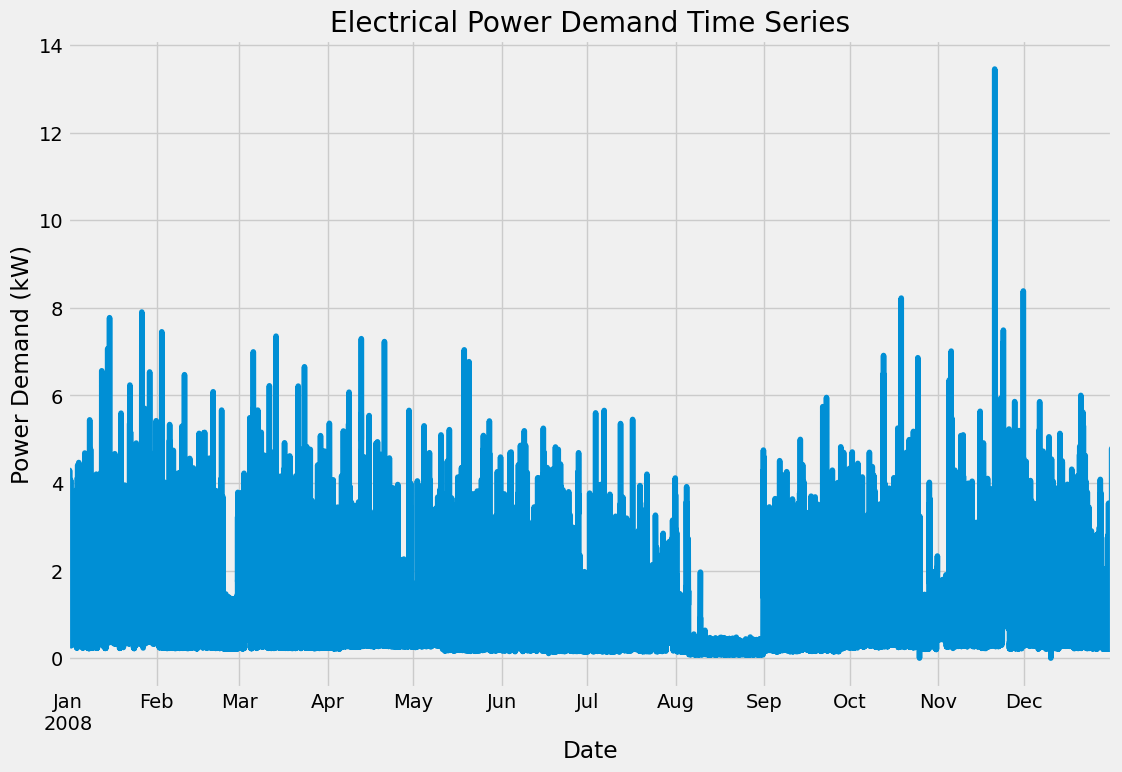

 Data visualization completed


In [81]:
# visualize the time series data
ax = df_clean.set_index('timestamp')['demand_kw'].plot(figsize=(12, 8))
ax.set_ylabel('Power Demand (kW)')
ax.set_xlabel('Date')
ax.set_title('Electrical Power Demand Time Series')
plt.show()

print(" Data visualization completed")

## 5. Prepare Data for Prophet

In [82]:
# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_df = df_clean[['timestamp', 'demand_kw']].copy()
prophet_df = prophet_df.rename(columns={'timestamp': 'ds', 'demand_kw': 'y'})

print(f"Prophet dataframe shape: {prophet_df.shape}")
print("Prophet dataframe preview:")
print(prophet_df.head())
print(" Data prepared for Prophet")

Prophet dataframe shape: (35136, 2)
Prophet dataframe preview:
                   ds         y
0 2008-01-01 00:00:00  1.568400
1 2008-01-01 00:15:00  1.562400
2 2008-01-01 00:30:00  1.679867
3 2008-01-01 00:45:00  1.577067
4 2008-01-01 01:00:00  1.632267
 Data prepared for Prophet


## 6. Prophet Model Training

In [83]:
# saved model
import os
import pickle   
MODEL_FILE = 'models/prophet_model.pkl'
use_existing = False #os.path.exists(MODEL_FILE)
os.makedirs(os.path.dirname(MODEL_FILE), exist_ok=True)
if use_existing:
    print(" Loading existing model...")
    with open(MODEL_FILE, 'rb') as f:
        model = pickle.load(f)
    print(" Model loaded successfully")
else:
    print(" Training new model...")
    best_params = {'changepoint_prior_scale': 0.11993666812461125, 'changepoint_range': 0.8994438318514382, 'seasonality_prior_scale': 8.337816994793926, 'holidays_prior_scale': 5.140132773594495}
    model = Prophet(interval_width=0.95,**best_params)

    model.fit(prophet_df)

    print(" Prophet model trained successfully")
    
    with open(MODEL_FILE, 'wb') as f:
        pickle.dump(model, f)
    print(" Model saved")

 Training new model...


18:06:45 - cmdstanpy - INFO - Chain [1] start processing
18:07:28 - cmdstanpy - INFO - Chain [1] done processing
18:07:28 - cmdstanpy - INFO - Chain [1] done processing


 Prophet model trained successfully
 Model saved


In [84]:
# import optuna
# from sklearn.metrics import mean_absolute_percentage_error

# df_train = prophet_df[:-30]  
# df_test = prophet_df[-30:]   
# def objective(trial):
#     params = {
#         'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
#         'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
#         'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10, log=True),
#         'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10, log=True),
#     }
    
#     model = Prophet(**params).add_country_holidays(country_name='SG')
#     model.fit(df_train)
#     preds = model.predict(df_test)
    
#     mape = mean_absolute_percentage_error(df_test['y'], preds['yhat'])
#     print(f"Trial params: {params}, MAPE: {mape}")
#     return mape

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)
# print(study.best_value)
# print(study.best_params)

## 7. Generate Future Predictions

In [85]:
future_dates = model.make_future_dataframe(periods=96, freq='15min')
print(f"Future dataframe shape: {future_dates.shape}")
print("Last few future dates:")
print(future_dates.tail())

forecast = model.predict(future_dates)
print(f"\nForecast dataframe shape: {forecast.shape}")
print("Forecast preview:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Future dataframe shape: (35232, 1)
Last few future dates:
                       ds
35227 2009-01-01 22:45:00
35228 2009-01-01 23:00:00
35229 2009-01-01 23:15:00
35230 2009-01-01 23:30:00
35231 2009-01-01 23:45:00

Forecast dataframe shape: (35232, 19)
Forecast preview:
                       ds      yhat  yhat_lower  yhat_upper
35227 2009-01-01 22:45:00  1.100590   -0.630239    2.729994
35228 2009-01-01 23:00:00  0.984780   -0.543192    2.633794
35229 2009-01-01 23:15:00  0.876406   -0.654240    2.468017
35230 2009-01-01 23:30:00  0.778103   -0.874854    2.387852
35231 2009-01-01 23:45:00  0.691678   -0.859408    2.337643

Forecast dataframe shape: (35232, 19)
Forecast preview:
                       ds      yhat  yhat_lower  yhat_upper
35227 2009-01-01 22:45:00  1.100590   -0.630239    2.729994
35228 2009-01-01 23:00:00  0.984780   -0.543192    2.633794
35229 2009-01-01 23:15:00  0.876406   -0.654240    2.468017
35230 2009-01-01 23:30:00  0.778103   -0.874854    2.387852
35231 2009-0

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

evaluation_df = pd.merge(prophet_df[['ds', 'y']], forecast[['ds', 'yhat']], left_on='ds', right_on='ds', how='inner')

mae = mean_absolute_error(evaluation_df['y'], evaluation_df['yhat'])
rmse = np.sqrt(mean_squared_error(evaluation_df['y'], evaluation_df['yhat']))
r2 = r2_score(evaluation_df['y'], evaluation_df['yhat'])

print("Prophet Model Evaluation:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R square: {r2:.4f}")

Prophet Model Evaluation:
MAE: 0.6092
RMSE: 0.8382
R square: 0.2990


## 9. Visualize Forecast Results

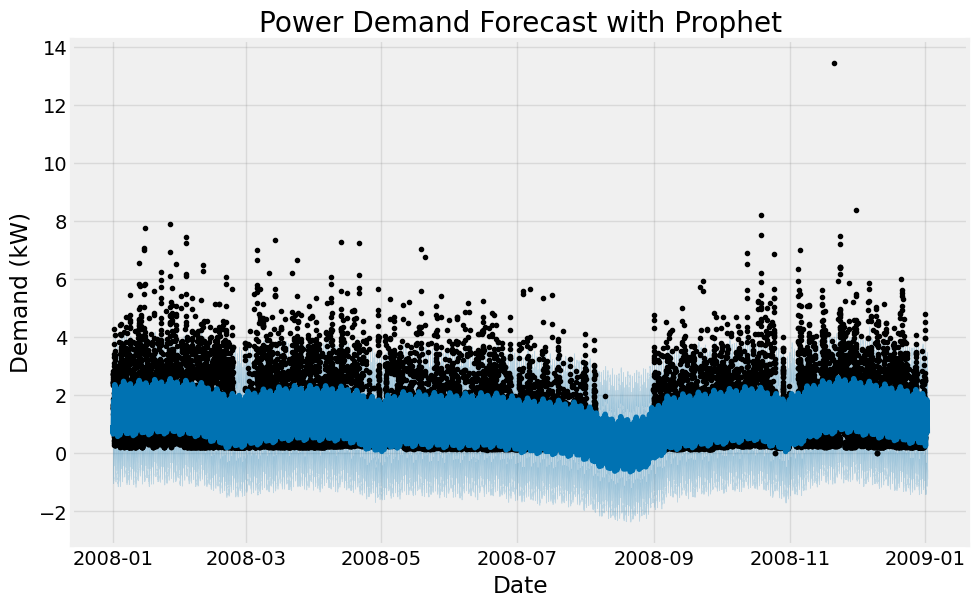

 Forecast visualization completed


In [87]:
fig = model.plot(forecast, uncertainty=True)
plt.title('Power Demand Forecast with Prophet')
plt.ylabel('Demand (kW)')
plt.xlabel('Date')
plt.show()

print(" Forecast visualization completed")

## 10. Forecast Components Analysis

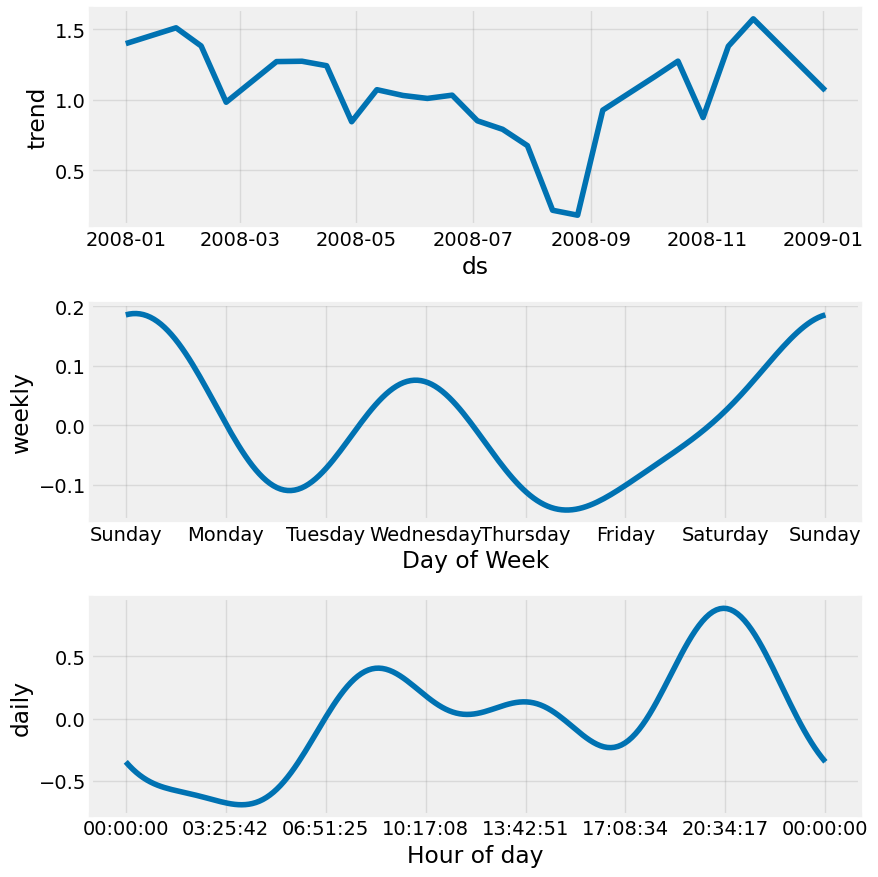

24-Hour Forecast Summary:
Average demand: 0.94 kW
Peak demand: 1.84 kW
Minimum demand: 0.25 kW


In [88]:
# trend, seasonality
fig = model.plot_components(forecast)
plt.show()

# display 24 hour forecast
forecast_24h = forecast.tail(96)  # last 96 periods (24 hours)
print("24-Hour Forecast Summary:")
print(f"Average demand: {forecast_24h['yhat'].mean():.2f} kW")
print(f"Peak demand: {forecast_24h['yhat'].max():.2f} kW")
print(f"Minimum demand: {forecast_24h['yhat'].min():.2f} kW")

forecast_24h[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('output/24h_forecast.csv', index=False)


## 11. Detailed Forecast Visualization

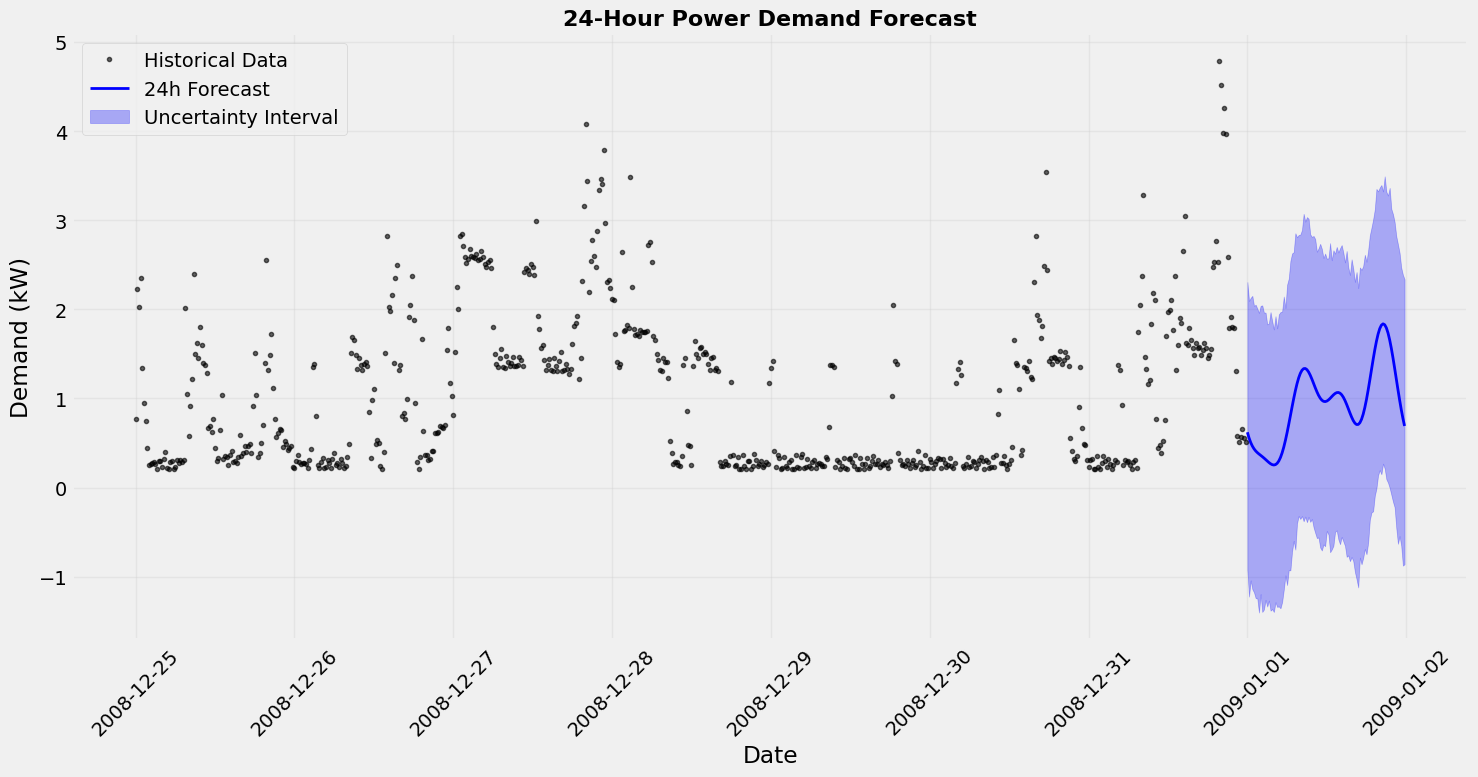

 Detailed forecast visualization completed


In [89]:

plt.figure(figsize=(15, 8))

# plot last 7 days
last_week = prophet_df.tail(7*24*4) 
plt.plot(last_week['ds'], last_week['y'], 'k.', alpha=0.6, label='Historical Data')

plt.plot(forecast_24h['ds'], forecast_24h['yhat'], 'b-', linewidth=2, label='24h Forecast')
plt.fill_between(forecast_24h['ds'], 
                 forecast_24h['yhat_lower'], 
                 forecast_24h['yhat_upper'], 
                 alpha=0.3, color='blue', label='Uncertainty Interval')

plt.title('24-Hour Power Demand Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Demand (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(" Detailed forecast visualization completed")

## 12. Conclusion

In [90]:

print("PROPHET MODEL FOR POWER DEMAND FORECASTING")
print("-"*60)

print("\n ACCOMPLISHED:")
print("1.  Data preprocessing and quality checks")
print("2. Prophet model training")
print("3. 24-hour ahead forecasting")
print("4. Forecast components analysis")
print("5. Comprehensive visualizations")

print(f"\n 24-HOUR FORECAST SUMMARY:")
print(f"Average Demand: {forecast_24h['yhat'].mean():.2f} kW")
print(f"Peak Demand:    {forecast_24h['yhat'].max():.2f} kW")
print(f"Minimum Demand: {forecast_24h['yhat'].min():.2f} kW")

print("\n KEY INSIGHTS:")
print("- Prophet successfully captures seasonal patterns in power demand")
print("- The model provides uncertainty intervals for risk assessment")
print("- Forecast components show clear daily and weekly seasonality")

print("\n OUTPUT:")
print("- 24h_forecast.csv: Next 24 hours predictions with confidence intervals")


PROPHET MODEL FOR POWER DEMAND FORECASTING
------------------------------------------------------------

 ACCOMPLISHED:
1.  Data preprocessing and quality checks
2. Prophet model training
3. 24-hour ahead forecasting
4. Forecast components analysis
5. Comprehensive visualizations

 24-HOUR FORECAST SUMMARY:
Average Demand: 0.94 kW
Peak Demand:    1.84 kW
Minimum Demand: 0.25 kW

 KEY INSIGHTS:
- Prophet successfully captures seasonal patterns in power demand
- The model provides uncertainty intervals for risk assessment
- Forecast components show clear daily and weekly seasonality

 OUTPUT:
- 24h_forecast.csv: Next 24 hours predictions with confidence intervals
